In [34]:
import pandas as pd
import simpy
import random
import statistics

# ---------------- Simulation Model ----------------
def run_clinic_simulation(NUM_COUNTERS=3, SERVICE_TIME=(7, 8), ARRIVAL_INTERVAL=(0.8, 1.5), SIM_TIME=480,verbose=False):
    RANDOM_SEED = 42
    random.seed(RANDOM_SEED)

    PHARMACISTS_PER_COUNTER = 2
    TOTAL_PHARMACISTS = NUM_COUNTERS * PHARMACISTS_PER_COUNTER

    env = simpy.Environment()
    pharmacists = [simpy.Resource(env, capacity=1) for _ in range(TOTAL_PHARMACISTS)]
    
    wait_times = []
    service_times = []
    queue_samples = []
    served_count = [0] * TOTAL_PHARMACISTS
    busy_time = [0.0] * TOTAL_PHARMACISTS

    # Monitor queue congestion
    def monitor():
        while True:
            total_q = sum(len(p.queue) for p in pharmacists)
            queue_samples.append(total_q)
            yield env.timeout(1)

    # Each patient process
    def patient(env, pid):
        arrival_time = env.now
        if verbose:
            print(f"Patient {pid} arrives at {arrival_time:.2f} min")

        pharmacist_id = random.randrange(TOTAL_PHARMACISTS)
        pharmacist = pharmacists[pharmacist_id]

        with pharmacist.request() as req:
            yield req
            start_service = env.now
            wait = env.now - arrival_time
            wait_times.append(wait)
            if verbose:
                print(f"Patient {pid} starts service at {start_service:.2f} after waiting {wait:.2f} min")

            service_time = random.uniform(*SERVICE_TIME)
            service_times.append(service_time)
            busy_time[pharmacist_id] += service_time
            served_count[pharmacist_id] += 1

            yield env.timeout(service_time)
            finish_time = env.now
            if verbose:
                print(f"Patient {pid} leaves at {finish_time:.2f} (service {service_time:.2f} min)")

    # Generate patients over time
    def generate_patients(env):
        pid = 0
        while True:
            pid += 1
            env.process(patient(env, pid))
            yield env.timeout(random.uniform(*ARRIVAL_INTERVAL))
            if env.now > SIM_TIME:
                break

    env.process(monitor())
    env.process(generate_patients(env))
    env.run(until=SIM_TIME)

    # ---------------- Results ----------------
    avg_wait = statistics.mean(wait_times) if wait_times else 0
    avg_service = statistics.mean(service_times) if service_times else 0
    avg_queue = statistics.mean(queue_samples) if queue_samples else 0
    total_served = sum(served_count)
    throughput = total_served / SIM_TIME
    throughput_per_hour = throughput * 60
    utilization = [(busy_time[i] / SIM_TIME) * 100 for i in range(TOTAL_PHARMACISTS)]
    avg_utilization = statistics.mean(utilization)

    return {
        "Pharmacists": TOTAL_PHARMACISTS,
        "Patients Served": total_served,
        "Avg Wait (min)": avg_wait,
        "Avg Service (min)": avg_service,
        "Avg Queue": avg_queue,
        "Utilization (%)": avg_utilization,
        "Throughput/hr": throughput_per_hour
    }

# ---------------- Run Scenarios ----------------
results = []

results.append({"Scenario": "Base Case"} | run_clinic_simulation())
results.append({"Scenario": "More Counters"} | run_clinic_simulation(NUM_COUNTERS=4))
results.append({"Scenario": "Faster Pharmacists"} | run_clinic_simulation(SERVICE_TIME=(4,5)))
results.append({"Scenario": "Heavy Rush"} | run_clinic_simulation(ARRIVAL_INTERVAL=(0.5,1.0)))


# ---------------- Convert to DataFrame ----------------
df = pd.DataFrame(results)
df = df.round(2)      
print(" District General Hospital - Horana (Clinic Dispensary)")
print("=== Peak Day Simulation Results ===")
print() 
print(df.to_string(index=False))



# print("\n\n--- Detailed Log Run ---")
# print("Baseline Scenario with Detailed Logs")
# run_clinic_simulation(NUM_COUNTERS=3, SERVICE_TIME=(7,8), ARRIVAL_INTERVAL=(0.8,1.5), SIM_TIME=480, verbose=True)
# print() 
# print("Scenario 1 - Add One Counter - More Pharmacists")
# run_clinic_simulation(NUM_COUNTERS=4, SERVICE_TIME=(7,8), ARRIVAL_INTERVAL=(0.8,1.5), SIM_TIME=480, verbose=True)
# print() 
# print("Scenario 2 - Faster Service (4.5-5.5 min)")
# run_clinic_simulation(NUM_COUNTERS=3, SERVICE_TIME=(4.5,5.5), ARRIVAL_INTERVAL=(0.8,1.5), SIM_TIME=480, verbose=True)
# print()
# print("Scenario 3 - Heavy rush (patients arrive faster")
# run_clinic_simulation(NUM_COUNTERS=3, SERVICE_TIME=(7,8), ARRIVAL_INTERVAL=(0.5,1.0), SIM_TIME=480, verbose=True)


 District General Hospital - Horana (Clinic Dispensary)
=== Peak Day Simulation Results ===

          Scenario  Pharmacists  Patients Served  Avg Wait (min)  Avg Service (min)  Avg Queue  Utilization (%)  Throughput/hr
         Base Case            6              366           32.46               7.51      30.52            95.39          45.75
     More Counters            8              400           11.33               7.52       9.59            78.29          50.00
Faster Pharmacists            6              414            3.36               4.51       2.88            64.77          51.75
        Heavy Rush            6              382           96.54               7.51     128.26            99.63          47.75


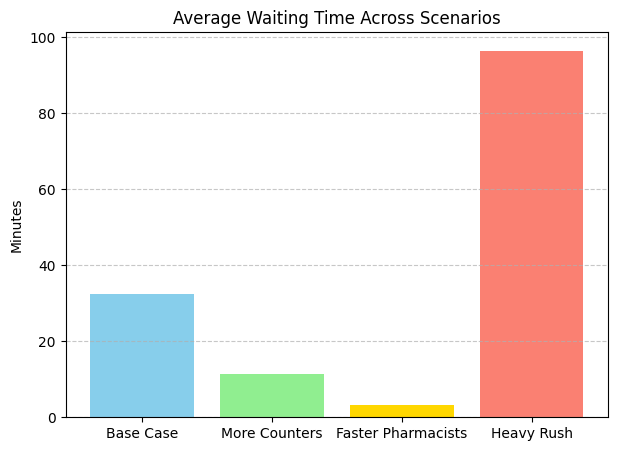

In [33]:
import matplotlib.pyplot as plt

plt.figure(figsize=(7,5))
plt.bar(df["Scenario"], df["Avg Wait (min)"], color=["skyblue","lightgreen","gold","salmon"])
plt.title("Average Waiting Time Across Scenarios")
plt.ylabel("Minutes")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


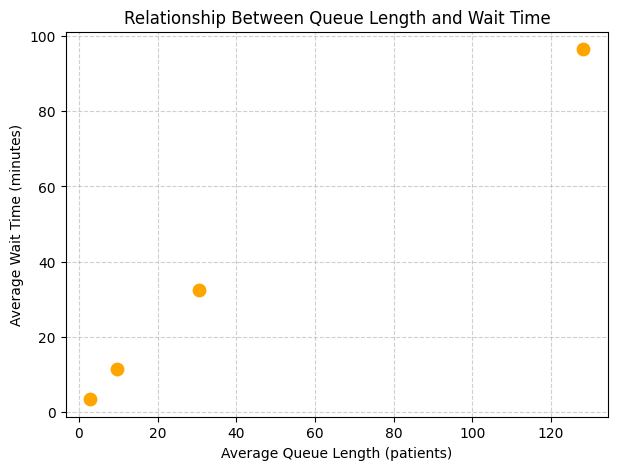

In [35]:
import matplotlib.pyplot as plt

plt.figure(figsize=(7,5))
plt.scatter(df["Avg Queue"], df["Avg Wait (min)"], color='orange', s=80)
plt.title("Relationship Between Queue Length and Wait Time")
plt.xlabel("Average Queue Length (patients)")
plt.ylabel("Average Wait Time (minutes)")
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()



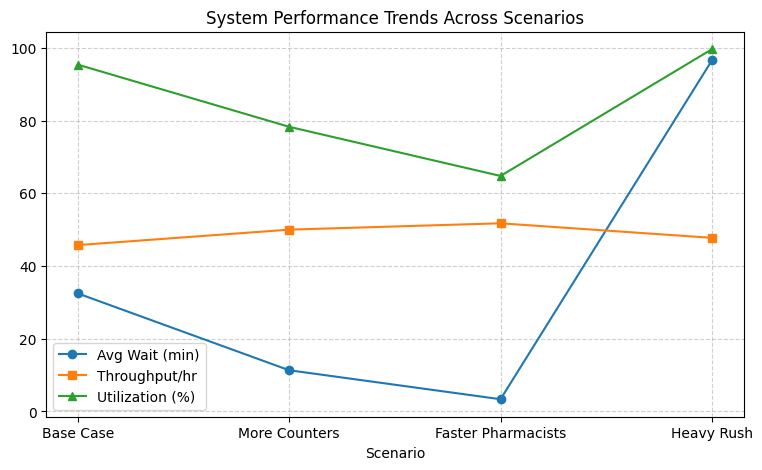

In [36]:
scenario_name = "Base Case"

plt.figure(figsize=(9,5))
plt.plot(df["Scenario"], df["Avg Wait (min)"], marker='o', label='Avg Wait (min)')
plt.plot(df["Scenario"], df["Throughput/hr"], marker='s', label='Throughput/hr')
plt.plot(df["Scenario"], df["Utilization (%)"], marker='^', label='Utilization (%)')
plt.title("System Performance Trends Across Scenarios")
plt.xlabel("Scenario")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()



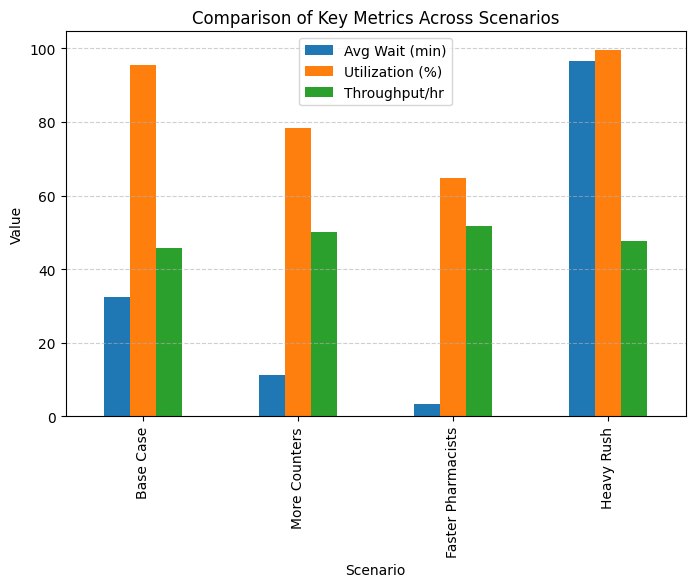

In [37]:
import matplotlib.pyplot as plt

df.plot(
    x="Scenario", 
    y=["Avg Wait (min)", "Utilization (%)", "Throughput/hr"], 
    kind="bar", 
    figsize=(8,5)
)
plt.title("Comparison of Key Metrics Across Scenarios")
plt.ylabel("Value")
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()

